# Setup

In [1]:
# Import standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn utilities
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold)
from sklearn.metrics import (confusion_matrix, f1_score, roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.tree import export_graphviz
import sklearn.base

# Import SHAP for model interpretability
import shap

# Import joblib for parallel processing
import joblib

# Load Data

In [2]:
# Load Preprocessed Data

data_dir = 'C:/Users/Bryan Chan/Documents/Projects/oral_contraception_over_time/data/'

# Load Data
df1_final = pd.read_csv(data_dir + 'df1_final.csv')
df2_final = pd.read_csv(data_dir + 'df2_final.csv')
df3_final = pd.read_csv(data_dir + 'df3_final.csv')
df4_final = pd.read_csv(data_dir + 'df4_final.csv')

# Drop Index Column
df1_final = df1_final.drop(df1_final.columns[0], axis=1)
df2_final = df2_final.drop(df2_final.columns[0], axis=1)
df3_final = df3_final.drop(df3_final.columns[0], axis=1)
df4_final = df4_final.drop(df4_final.columns[0], axis=1)


In [ ]:
# Preview data
df1_final.head(3)

# Split Data

In [3]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

# List of cleaned DataFrames
dfs_final = [df1_final, df2_final, df3_final, df4_final]

# Initialize lists to store train/test splits
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Loop through each DataFrame and perform the train/test split
for df in dfs_final:
    X = df.drop(['hormon_iudor'], axis=1)
    y = df['hormon_iudor']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Access the splits for each DataFrame
X1_train, X1_test, y1_train, y1_test = X_train_list[0], X_test_list[0], y_train_list[0], y_test_list[0]
X2_train, X2_test, y2_train, y2_test = X_train_list[1], X_test_list[1], y_train_list[1], y_test_list[1]
X3_train, X3_test, y3_train, y3_test = X_train_list[2], X_test_list[2], y_train_list[2], y_test_list[2]
X4_train, X4_test, y4_train, y4_test = X_train_list[3], X_test_list[3], y_train_list[3], y_test_list[3]

In [7]:
# Plot the Frequency Distribution of 0 and 1 in the Target Variable
#unique values in the y1_train
print(y1_train.value_counts())
print(y2_train.value_counts())
print(y3_train.value_counts())
print(y4_train.value_counts())

hormon_iudor
1    325
0    204
Name: count, dtype: int64
hormon_iudor
1    416
0    100
Name: count, dtype: int64
hormon_iudor
0    260
1    164
Name: count, dtype: int64
hormon_iudor
1    274
0    256
Name: count, dtype: int64


In [85]:
# View list of columns
print(X1_train.columns)

Index(['wave', 'nkids', 'pinc_decile', 'hhincnet_decile', 'edu', 'health',
       'bmi_category', 'val1i3', 'val1i4', 'val1i5', 'extraversion',
       'agreeableness', 'conscientiousness', 'neuroticism', 'openness', 'rel',
       'urban_X1', 'sex_often_X1', 'abortion_X1', 'migback_X1', 'relstat_LAT',
       'relstat_Married', 'relstat_Single',
       'empl_Full.time.or.self.employment',
       'empl_Marginal.or.part.time.employment', 'ethni_German.native',
       'ethni_Half.German', 'ethni_Other.non.German.background',
       'ethni_Turkish.background', 'region_Eastern.Germany',
       'region_Western.Germany', 'addchild_Unsure', 'addchild_Yes',
       'denomination_None', 'denomination_Other', 'denomination_Protestant',
       'denomination_Roman.Catholic'],
      dtype='object')


In [7]:
# Feature Names

feature_names_list = [
    "Survey year",  # wave
    "Number of children",  # nkids
    "Personal net income",  # pinc_decile
    "Household net income",  # hhincnet_decile
    "Educational level",  # edu
    "General health",  # health
    "Body Mass Index",  # bmi_category
    "Values: Female employment",  # val1i3
    "Values: Division of housework",  # val1i4
    "Values: Maternal employment",  # val1i5
    "Big 5: Extraversion",  # extraversion
    "Big 5: Agreeableness",  # agreeableness
    "Big 5: Conscientiousness",  # conscientiousness
    "Big 5: Neuroticism",  # neuroticism
    "Big 5: Openness",  # openness
    "Religious event attendance",  # rel
    "Urbanity of region",  # urban_X1
    "Frequent sexual intercourse",  # sex_often_X1
    "Abortion experience",  # abortion_X1
    "Migration background",  # migback_X1
    "Relationship status: LAT",  # relstat_LAT
    "Relationship status: Married",  # relstat_Married
    "Relationship status: Single",  # relstat_Single
    "Labor force status: Full time or self employment",  # empl_Full.time.or.self.employment
    "Labor force status: Marginal or part time employment",  # empl_Marginal.or.part.time.employment
    "Ethnicity: German native",  # ethni_German.native
    "Ethnicity: Half German",  # ethni_Half.German
    "Ethnicity: Other non German background",  # ethni_Other.non.German.background
    "Ethnicity: Turkish background",  # ethni_Turkish.background
    "Region of birth: Eastern Germany",  # region_Eastern.Germany
    "Region of birth: Western Germany",  # region_Western.Germany
    "Additional children planned: Unsure",  # addchild_Unsure
    "Additional children planned: Yes",  # addchild_Yes
    "Religious denomination: None",  # denomination_None
    "Religious denomination: Other",  # denomination_Other
    "Religious denomination: Protestant",  # denomination_Protestant
    "Religious denomination: Roman Catholic"  # denomination_Roman.Catholic
]


In [84]:
# what is the n_sample for each X_train
print(X1_train.shape)
print(X2_train.shape)
print(X3_train.shape)
print(X4_train.shape)

(529, 37)
(516, 37)
(424, 37)
(530, 37)


# Fit Models

In [3]:
# Import Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

## Decision Trees

In [29]:
# Set Parameters Values
max_depth_full=list(range(5,21))
min_samples_split_full = list(range(2,41))

In [30]:
# Hyperparmeter Tuning - Random Search

model_dt = DecisionTreeClassifier(random_state=666)
distributions = dict(max_depth = max_depth_full, 
                     min_samples_split = min_samples_split_full)

clf_dt = RandomizedSearchCV(model_dt, distributions, n_iter=100, verbose=2,
                            scoring='f1',  # Use an appropriate scoring metric for classification
                            refit='f1',    # Refit the model using the best scoring metric
                            cv=5, 
                            random_state=666)

# Fit the model to Search
search = clf_dt.fit(X1_train, y1_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=7, min_sa

In [31]:
# Select Best parameters
best_params = search.best_params_

print(f"Best parameters found: {search.best_params_}")
print(f"Best F1 score: {search.best_score_}")

Best parameters found: {'min_samples_split': 25, 'max_depth': 5}
Best F1 score: 0.7004470575112519


In [12]:
# Fit Final Model with Tuned Hyperparameters
best_params = search.best_params_
dt_final1 = DecisionTreeClassifier(**best_params, random_state=666)

# Fit the model
dt_final1.fit(X1_train, y1_train)

# Predict on the test set
pred_test_dt1 = dt_final1.predict(X1_test)

# Evaluate the model using appropriate classification metrics
print(f"Accuracy: {accuracy_score(y1_test, pred_test_dt1)}")
print(f"F1 Score: {f1_score(y1_test, pred_test_dt1)}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_test_dt1)}")

Accuracy: 0.5714285714285714
F1 Score: 0.6984126984126984
ROC AUC Score: 0.5103141115799343


## Random Forest

### Hyperparmeter: Random Search

In [91]:
# Set UP Random Search

n_estimators_full=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]

distributions = dict(
    n_estimators= n_estimators_full,            # Number of trees
    max_depth=[None, 10, 20, 30, 40, 50],       # Maximum depth of each tree
    min_samples_split=[2, 5, 10, 14, 20],       # Minimum number of samples required to split an internal node
    min_samples_leaf=[1, 2, 4, 6, 8],           # Minimum number of samples required to be at a leaf node
    class_weight = ['balanced', None], # Include class_weight in the search space
    bootstrap = [True, False],  # Include bootstrap in the search space
    max_features=['sqrt', 'log2']  # Include max_features in the search space
)

# Hyperparmeter Tuning - Random Search
model_rf = RandomForestClassifier(random_state=666)

scoring = {'roc_auc': 'roc_auc',
           'f1': make_scorer(f1_score, pos_label=1) }

# Set up the RandomizedSearchCV
clf_rf = RandomizedSearchCV(model_rf, param_distributions = distributions,
                            n_iter=100,
                            verbose=2,
                            n_jobs=4,
                            scoring= scoring,  # Use appropriate scoring metric for classification
                            refit='roc_auc',    # Refit the model using the best scoring metric
                            cv=7,
                            random_state=666)


In [72]:
# Run the search
random_searchX1 = clf_rf.fit(X1_train, y1_train)
joblib.dump(random_searchX1, 'random_searchX1.pkl')
print(f"X1's Best parameters from the Random Search: {random_searchX1.best_params_}")
print(f"X1's Best ROC-AUC score from the Random Search: {random_searchX1.best_score_}")
print(f"X1's Best F1 score from the Random Search: {max(random_searchX1.cv_results_['mean_test_f1'])}")

random_searchX2 = clf_rf.fit(X2_train, y2_train)
joblib.dump(random_searchX2, 'random_searchX2.pkl')
print(f"X2's Best parameters from the Random Search: {random_searchX2.best_params_}")
print(f"X2's Best ROC-AUC score from the Random Search: {random_searchX2.best_score_}")
print(f"X2's Best F1 score from the Random Search: {max(random_searchX2.cv_results_['mean_test_f1'])}")

random_searchX3 = clf_rf.fit(X3_train, y3_train)
joblib.dump(random_searchX3, 'random_searchX3.pkl')
print(f"X3's Best parameters from the Random Search: {random_searchX3.best_params_}")
print(f"X3's Best ROC-AUC score from the Random Search: {random_searchX3.best_score_}")
print(f"X3's Best F1 score from the Random Search: {max(random_searchX3.cv_results_['mean_test_f1'])}")

random_searchX4 = clf_rf.fit(X4_train, y4_train)
joblib.dump(random_searchX4, 'random_searchX4.pkl')
print(f"X4's Best parameters from the Random Search: {random_searchX4.best_params_}")
print(f"X4's Best ROC-AUC score from the Random Search: {random_searchX4.best_score_}")
print(f"X4's Best F1 score from the Random Search: {max(random_searchX4.cv_results_['mean_test_f1'])}")

Best parameters from the Random Search: {'n_estimators': 400, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': False}
Best ROC-AUC score from the Random Search: 0.6826253286730495
Best F1 score from the Random Search: 0.7475731163313223
Fitting 7 folds for each of 100 candidates, totalling 700 fits
Best parameters from the Random Search: {'n_estimators': 600, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}
Best ROC-AUC score from the Random Search: 0.6476795803066988
Best F1 score from the Random Search: 0.8919818923014379
Fitting 7 folds for each of 100 candidates, totalling 700 fits
Best parameters from the Random Search: {'n_estimators': 1750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': False}
Best ROC-AUC score from the Random Sea

In [4]:
# Load up the Fitted RandomizedSearchCV objects
random_searchX1 = joblib.load('random_searchX1.pkl')
random_searchX2 = joblib.load('random_searchX2.pkl')
random_searchX3 = joblib.load('random_searchX3.pkl')
random_searchX4 = joblib.load('random_searchX4.pkl')

### Select Best

In [131]:
# Select Best parameters and Fit Final Model
best_paramsX1 = random_searchX1.best_params_
rf_final1 = RandomForestClassifier(**best_paramsX1, random_state=666)
rf_final1.fit(X1_train, y1_train)
pred_trainX1_rf = rf_final1.predict(X1_train)

best_paramsX2 = random_searchX2.best_params_
rf_final2 = RandomForestClassifier(**best_paramsX2, random_state=666)
rf_final2.fit(X2_train, y2_train)
pred_trainX2_rf = rf_final2.predict(X2_train)

best_paramsX3 = random_searchX3.best_params_
rf_final3 = RandomForestClassifier(**best_paramsX3, random_state=666)
rf_final3.fit(X3_train, y3_train)
pred_trainX3_rf = rf_final3.predict(X3_train)

best_paramsX4 = random_searchX4.best_params_
rf_final4 = RandomForestClassifier(**best_paramsX4, random_state=666)
rf_final4.fit(X4_train, y4_train)
pred_trainX4_rf = rf_final4.predict(X4_train)

In [105]:
# Evaluate the model
print(f"X1's Accuracy: {accuracy_score(y1_train, pred_trainX1_rf)}")
print(f"X1's F1 Score: {f1_score(y1_train, pred_trainX1_rf)}")
print(f"X1's ROC AUC Score: {roc_auc_score(y1_train, pred_trainX1_rf)}")
print()

print(f"X2's Accuracy: {accuracy_score(y2_train, pred_trainX2_rf)}")
print(f"X2's F1 Score: {f1_score(y2_train, pred_trainX2_rf)}")
print(f"X2's ROC AUC Score: {roc_auc_score(y2_train, pred_trainX2_rf)}")
print()

print(f"X3's Accuracy: {accuracy_score(y3_train, pred_trainX3_rf)}")
print(f"X3's F1 Score: {f1_score(y3_train, pred_trainX3_rf)}")
print(f"X3's ROC AUC Score: {roc_auc_score(y3_train, pred_trainX3_rf)}")
print()

print(f"X4's Accuracy: {accuracy_score(y4_train, pred_trainX4_rf)}")
print(f"X4's F1 Score: {f1_score(y4_train, pred_trainX4_rf)}")
print(f"X4's ROC AUC Score: {roc_auc_score(y4_train, pred_trainX4_rf)}")

X1's Accuracy: 0.9603024574669187
X1's F1 Score: 0.9672386895475819
X1's ROC AUC Score: 0.9622171945701358

X2's Accuracy: 0.998062015503876
X2's F1 Score: 0.9987995198079231
X2's ROC AUC Score: 0.995

X3's Accuracy: 1.0
X3's F1 Score: 1.0
X3's ROC AUC Score: 1.0

X4's Accuracy: 0.9962264150943396
X4's F1 Score: 0.9963636363636363
X4's ROC AUC Score: 0.99609375


### Plot Model's Metrics

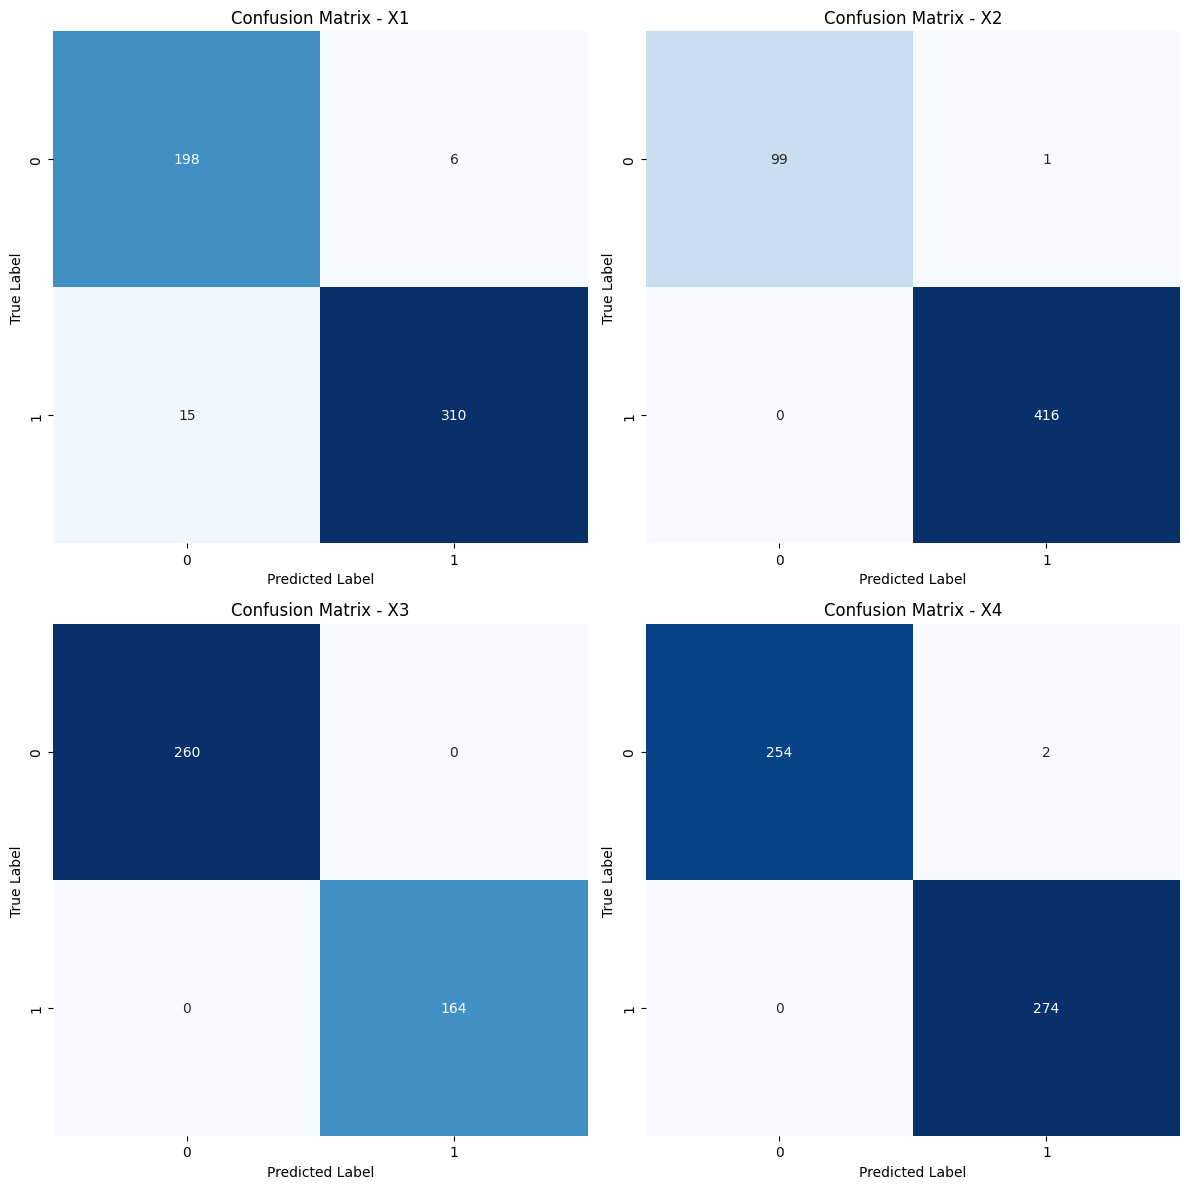

In [94]:
def plot_confusion_matrices(y_true_list, y_pred_list, titles, figsize=(12, 12)):
    """
    Plots confusion matrices in a 2x2 grid.

    Parameters:
    y_true_list (list): List of true labels for each dataset.
    y_pred_list (list): List of predicted labels for each dataset.
    titles (list): List of titles for each subplot.
    figsize (tuple): Size of the figure.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    for i, (y_true, y_pred, title) in enumerate(zip(y_true_list, y_pred_list, titles)):
        row, col = divmod(i, 2)
        conf_mat = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, col])
        axes[row, col].set_xlabel('Predicted Label')
        axes[row, col].set_ylabel('True Label')
        axes[row, col].set_title(title)
    
    plt.tight_layout()
    plt.show()

# True labels and predicted labels for each dataset
y_true_list = [y1_train, y2_train, y3_train, y4_train]
y_pred_list = [pred_trainX1_rf, pred_trainX2_rf, pred_trainX3_rf, pred_trainX4_rf]
titles = ['Confusion Matrix - X1', 'Confusion Matrix - X2', 'Confusion Matrix - X3', 'Confusion Matrix - X4']

# Plot the confusion matrices
plot_confusion_matrices(y_true_list, y_pred_list, titles)

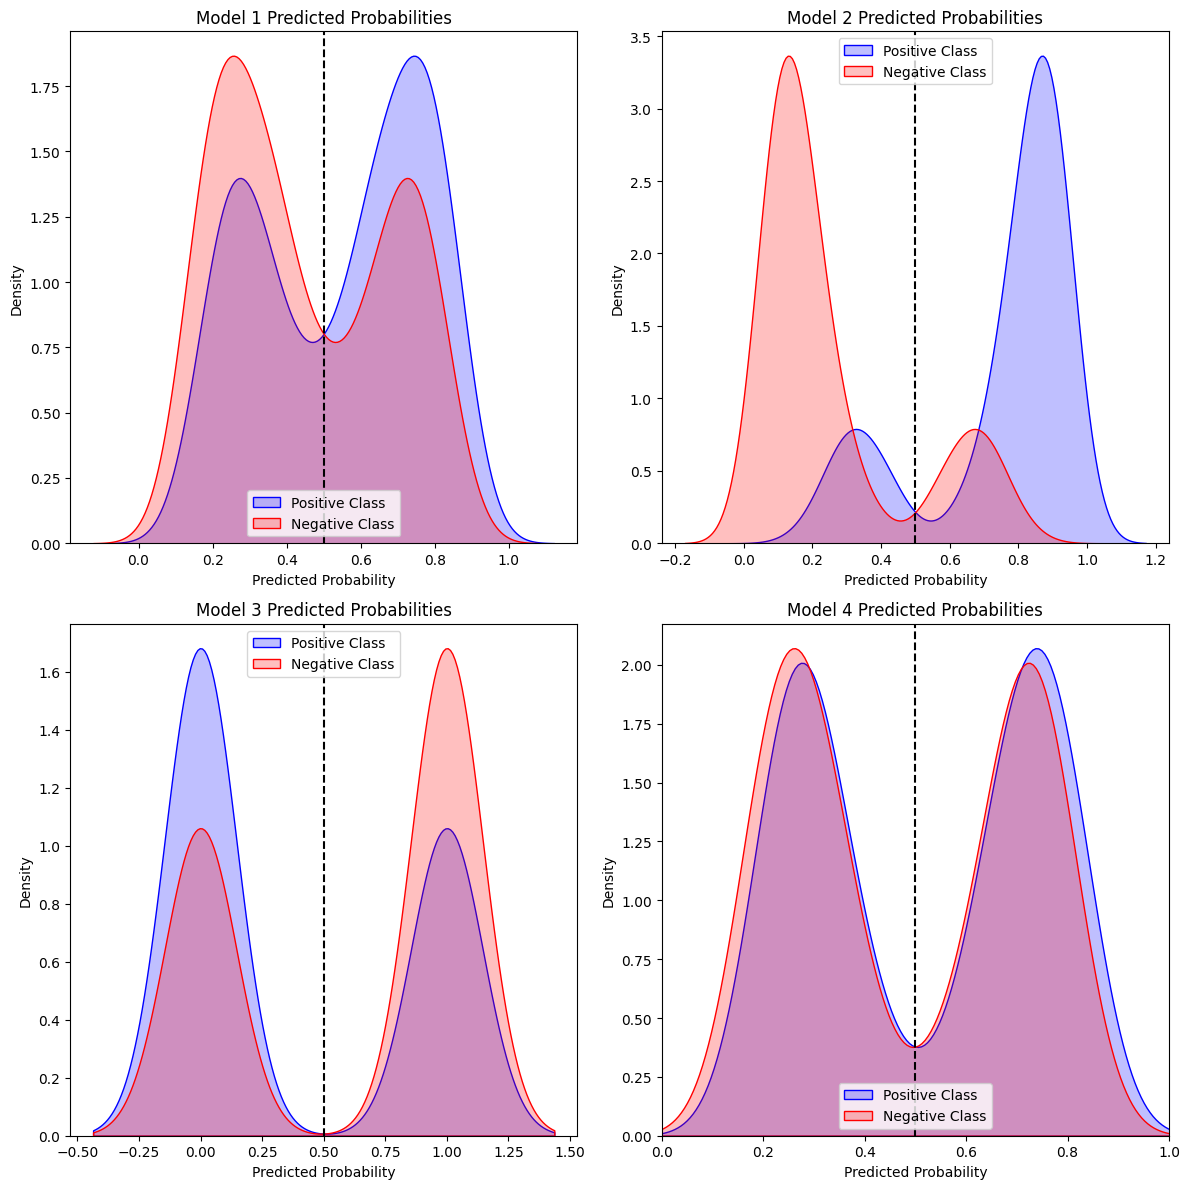

In [128]:
# Plot Predicted Probabilities

def plot_predicted_probabilities(models, X_train_list, titles, figsize=(12, 12)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    for i, (model, X_train, title) in enumerate(zip(models, X_train_list, titles)):
        row, col = divmod(i, 2)
        y_train_pred_prob_pos = model.predict_proba(X_train)[:, 1]
        y_train_pred_prob_neg = model.predict_proba(X_train)[:, 0]
        
        sns.kdeplot(y_train_pred_prob_pos, fill=True, color='b', label='Positive Class', ax=axes[row, col])
        sns.kdeplot(y_train_pred_prob_neg, fill=True, color='r', label='Negative Class', ax=axes[row, col])
    
        axes[row, col].axvline(0.5, color='k', linestyle='--')
        axes[row, col].set_xlabel('Predicted Probability')
        axes[row, col].set_ylabel('Density')
        axes[row, col].set_title(title)
        axes[row, col].legend()
   
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have four trained models and their corresponding training datasets
models = [rf_final1, rf_final2, rf_final3, rf_final4]
X_train_list = [X1_train, X2_train, X3_train, X4_train]
titles = ['Model 1 Predicted Probabilities', 'Model 2 Predicted Probabilities', 
          'Model 3 Predicted Probabilities', 'Model 4 Predicted Probabilities']

# Plot the predicted probabilities
plot_predicted_probabilities(models, X_train_list, titles) 



Text(0.5, 1.0, 'ROC Curve')

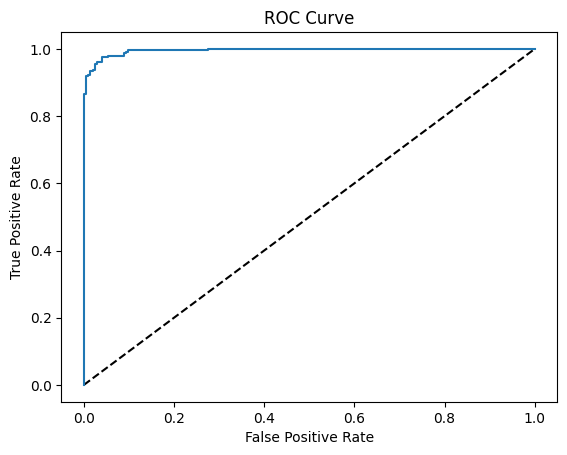

In [9]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

# Get predicted probabilities
y1_train_pred_prob = rf_final1.predict_proba(X1_train)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y1_train, y1_train_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')


### Fit on Unseen Data

In [14]:
# Predict on the Unseen Data
pred_testX1_rf = rf_final1.predict(X1_test)
#pred_testX2_rf = rf_final2.predict(X2_test)
#pred_testX3_rf = rf_final3.predict(X3_test)
#pred_testX4_rf = rf_final4.predict(X4_test)

In [17]:
# Evaluate Model on Unseen Data
print("DATA FRAME 1")
print(f"Accuracy: {accuracy_score(y1_test, pred_testX1_rf)}")
print(f"F1 Score: {f1_score(y1_test, pred_testX1_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_testX1_rf)}")

print("DATA FRAME 2")
print(f"Accuracy: {accuracy_score(y2_test, pred_testX2_rf)}")
print(f"F1 Score: {f1_score(y2_test, pred_testX2_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y2_test, pred_testX2_rf)}")

print("DATA FRAME 3")
print(f"Accuracy: {accuracy_score(y3_test, pred_testX3_rf)}")
print(f"F1 Score: {f1_score(y3_test, pred_testX3_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y3_test, pred_testX3_rf)}")

print("DATA FRAME 4")
print(f"Accuracy: {accuracy_score(y4_test, pred_testX4_rf)}")
print(f"F1 Score: {f1_score(y4_test, pred_testX4_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y4_test, pred_testX4_rf)}")

DATA FRAME 1
Accuracy: 0.5939849624060151
F1 Score: 0.6707317073170732
ROC AUC Score: 0.5703234880450071


### Hyperparameter: Grid Search

In [78]:
# Hyperparmeter Tuning - Grid Search 1st Iteration
param_grid1 = {
    'n_estimators': [50, 100, 200, 300, 500, 1000, 1250, 1500, 1750, 2000], # Number of trees in the forest.
    'max_depth': [2, 5, 10, 20, 30, 40],                                    # Maximum depth of each tree.
    'min_samples_split': [2, 5, 10, 20, 30, 35]                             # Minimum number of samples to split a node.
}

# Set up the first GridSearchCV
grid_search = GridSearchCV(model_rf, param_grid1,
                            scoring='roc_auc',
                            refit='roc_auc',
                            cv=7,
                            verbose=2,
                            n_jobs=4)

# Perform the first Grid Search
grid_searchX1_1st = grid_search.fit(X1_train, y1_train)
#grid_searchX2_1st = grid_search.fit(X2_train, y2_train)
#grid_searchX3_1st = grid_search.fit(X3_train, y3_train)
#grid_searchX4_1st = grid_search.fit(X4_train, y4_train)

Fitting 7 folds for each of 360 candidates, totalling 2520 fits


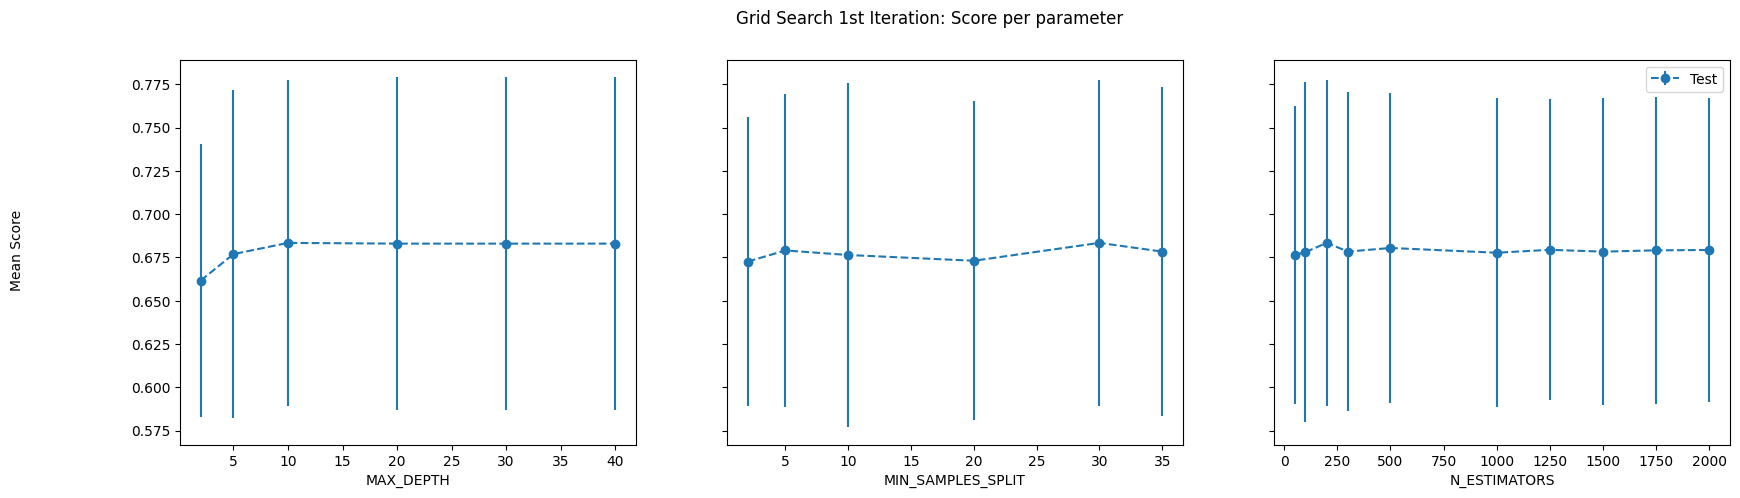

In [80]:
# Results of 1st Grid Search
import numpy as np
import matplotlib.pyplot as plt

def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object (e.g., grid_searchX1_1st).
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results.get('mean_train_score', None)  # In case training scores are not available
    stds_train = results.get('std_train_score', None)

    ## Getting indexes of values per hyper-parameter
    masks = []
    masks_names = list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(np.array(results['param_' + p_k].data) == p_v)

    params = grid.param_grid

    ## Plotting results
    fig, ax = plt.subplots(1, len(params), sharex='none', sharey='all', figsize=(20, 5))
    fig.suptitle('Grid Search 1st Iteration: Score per parameter')
    fig.text(0.04, 0.5, 'Mean Score', va='center', rotation='vertical')

    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        best_params_mask = m.all(axis=0)
        best_index = np.where(best_params_mask)[0]
        x = np.array(params[p])  # Hyperparameter values for current parameter
        y_1 = np.array(means_test[best_index])  # Test scores
        e_1 = np.array(stds_test[best_index])  # Test score std deviations

        if means_train is not None:
            y_2 = np.array(means_train[best_index])  # Training scores
            e_2 = np.array(stds_train[best_index])  # Training score std deviations
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='Test')
            ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^', label='Train')
        else:
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='Test')

        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

plot_search_results(grid_searchX1_1st)


In [81]:
# Refined Grid
refined_param_grid_X1 = {
    'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000],  # Narrowed based on the initial results
    'max_depth': list(range(4, 11)),
    'min_samples_split': list(range(10, 21))
}

refined_param_grid_X2 = {
    'n_estimators': [50, 300],  # Narrowed based on the initial results
    'max_depth': [2, 20],
    'min_samples_split': [10, 30]
}

refined_param_grid_X3 = {
    'n_estimators': [50, 300],  # Narrowed based on the initial results
    'max_depth': [2, 20],
    'min_samples_split': [10, 30]
}

refined_param_grid_X4 = {
    'n_estimators': [50, 300],  # Narrowed based on the initial results
    'max_depth': [2, 20],
    'min_samples_split': [10, 30]
}


In [82]:
# Hyperparmeter Tuning - Grid Search 2nd Iteration
refined_grid_search = GridSearchCV(model_rf, param_grid = refined_param_grid_X1,
                                   scoring='roc_auc',
                                   refit='roc_auc',
                                   cv=7,
                                   verbose=2,
                                   n_jobs=4)

grid_searchX1_final = refined_grid_search.fit(X_train, y_train)
joblib.dump(grid_searchX1_final, 'grid_searchX1_final.pkl')

print(f"Best parameters from the Random Search: {grid_searchX1_final.best_params_}")
print(f"Best ROC-AUC score from the Random Search: {grid_searchX1_final.best_score_}")

Fitting 7 folds for each of 616 candidates, totalling 4312 fits


c:\Users\chanho\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters from the Random Search: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 700}
Best F1 score from the Random Search: 0.6695858633358635


In [31]:
# Fit Final Model with Tuned Hyperparameters
best_params = grid_searchX1_final.best_params_
rf_final1 = RandomForestClassifier(**best_params, random_state=666)

rf_final1.fit(X1_train, y1_train)

# Predict on the test set
pred_testX1_rf = rf_final1.predict(X1_test)

# Evaluate the model using appropriate classification metrics
print(f"Accuracy: {accuracy_score(y1_test, pred_testX1_rf)}")
print(f"F1 Score: {f1_score(y1_test, pred_testX1_rf)}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_testX1_rf)}")


Accuracy: 0.6165413533834586
F1 Score: 0.7213114754098361
ROC AUC Score: 0.5658696671354899


## XGBoost

In [36]:
learning_rate_full = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

n_estimators_full=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

max_depth_full=list(range(5,21))


In [39]:
model_xgb = GradientBoostingClassifier(random_state=666)

distributions = dict(n_estimators = n_estimators_full,
                     max_depth = max_depth_full, 
                     learning_rate = learning_rate_full)

clf_xgb = RandomizedSearchCV(model_xgb, distributions, 
                             n_iter=100,
                             verbose=2,
                             n_jobs=4,
                             scoring='f1',
                             refit= 'f1',
                             cv=5, 
                             random_state=666)

search_xgb = clf_xgb.fit(X_train, y_train)

print(f"Best parameters from the Random Search: {search_xgb.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters from the Random Search: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.0001}


In [40]:
# Fit Final Model with Tuned Hyperparameters
best_params = search_xgb.best_params_
xgb_final1 = GradientBoostingClassifier(**best_params, random_state=666)

# Fit the model
xgb_final1.fit(X1_train, y1_train)

# Predict on the test set
pred_test_xgb1 = xgb_final1.predict(X1_test)

# Evaluate the model using appropriate classification metrics
print(f"Accuracy: {accuracy_score(y1_test, pred_test_xgb1)}")
print(f"F1 Score: {f1_score(y1_test, pred_test_xgb1)}")
print(f"ROC AUC Score: {roc_auc_score(y1_test, pred_test_xgb1)}")

Accuracy: 0.5939849624060151
F1 Score: 0.7452830188679245
ROC AUC Score: 0.5


## SHAP Implementation


### Shap Values

In [100]:
# Create the Explainer objects for each X_train
explainer_Kernel1 = shap.KernelExplainer(rf_final1.predict_proba, X1_train) # Kernel explainer
explainer_Tree1 = shap.TreeExplainer(rf_final1, X1_train) # Tree explainer

explainer_Kernel2 = shap.KernelExplainer(rf_final2.predict_proba, X2_train) # Kernel explainer
explainer_Tree2 = shap.TreeExplainer(rf_final2, X2_train) # Tree explainer

explainer_Kernel3 = shap.KernelExplainer(rf_final3.predict_proba, X3_train) # Kernel explainer
explainer_Tree3 = shap.TreeExplainer(rf_final3, X3_train) # Tree explainer

explainer_Kernel4 = shap.KernelExplainer(rf_final4.predict_proba, X4_train) # Kernel explainer
explainer_Tree4 = shap.TreeExplainer(rf_final4, X4_train) # Tree explainer


Using 529 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 516 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 424 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 530 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [11]:
# Calculate Kernel Shap Values
shap_values_Kernel = explainer_Kernel.shap_values(X1_train)

joblib.dump(shap_values_Kernel, 'shap_values_Kernel.pkl') # Save Shap values


  0%|          | 0/529 [00:00<?, ?it/s]

100%|██████████| 529/529 [3:50:34<00:00, 26.15s/it]  


In [138]:
# Create Tree Shap Values
shap_values_Tree1 = explainer_Tree1.shap_values(X1_train)
joblib.dump(shap_values_Tree1, 'shap_values_Tree1.pkl') # Save Shap values

shap_values_Tree2 = explainer_Tree2.shap_values(X2_train, check_additivity=False)
joblib.dump(shap_values_Tree2, 'shap_values_Tree2.pkl') # Save Shap values

shap_values_Tree3 = explainer_Tree3.shap_values(X3_train)
joblib.dump(shap_values_Tree3, 'shap_values_Tree3.pkl') # Save Shap values

shap_values_Tree4 = explainer_Tree4.shap_values(X4_train, check_additivity=False)
joblib.dump(shap_values_Tree4, 'shap_values_Tree4.pkl') # Save Shap values


['shap_values_Tree2.pkl']

In [5]:
# Load up Shap values
#hap_values_Kernel = joblib.load('shap_values_Kernel.pkl')

shap_values_Tree1 = joblib.load('pickles/shap_values_Tree1.pkl')
shap_values_Tree2 = joblib.load('pickles/shap_values_Tree2.pkl')
shap_values_Tree3 = joblib.load('pickles/shap_values_Tree3.pkl')
shap_values_Tree4 = joblib.load('pickles/shap_values_Tree4.pkl')

### Recursive Feature Elimination (RFE)

In [139]:
# Custom cross-validation function
def cross_val_scores(model, X_train, y_train, cv=5,
                     metrics=[f1_score, roc_auc_score]):
    
    X_train_re = X_train.reset_index(drop=True)
    y_train_re = y_train.reset_index(drop=True)
    
    kf = KFold(n_splits= cv, random_state = 666, shuffle= True)
    kf.get_n_splits(X_train, y_train)

    scores = [[] for metric in metrics]
    j=1

    for tune_index, eval_index in kf.split(X_train, y_train):
        print(f'Fold {j}')
        model_clone = sklearn.base.clone(model)
        X_tune, X_eval = X_train_re.iloc[tune_index,:], X_train_re.iloc[eval_index,:]
        y_tune, y_eval = y_train_re[tune_index], y_train_re[eval_index]

        model_clone.fit(X_tune,y_tune)
        y_pred = model_clone.predict(X_eval)
        y_pred_proba = model_clone.predict_proba(X_eval)[:, 1]  # For ROC-AUC (probabilities)
        
        for i, metric in enumerate(metrics):
            if metric == roc_auc_score:
                score = metric(y_eval, y_pred_proba)
            else:
                score = metric(y_eval, y_pred)
            scores[i].append(score)

        j += 1
    return scores

In [140]:
# Calculate mean SHAP values
shap_absmean_1 = np.mean(np.abs(shap_values_Tree1[:, :, 1]), axis=0)
shap_absmean_2 = np.mean(np.abs(shap_values_Tree2[:, :, 1]), axis=0)
shap_absmean_3 = np.mean(np.abs(shap_values_Tree3[:, :, 1]), axis=0)
shap_absmean_4 = np.mean(np.abs(shap_values_Tree4[:, :, 1]), axis=0)

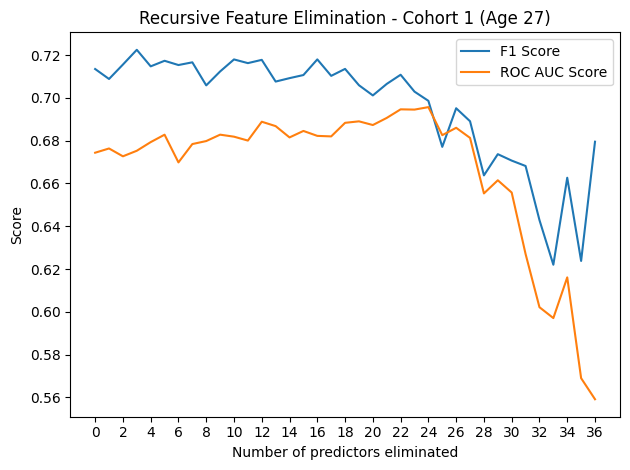

In [145]:
# RFE - X1
X1_rfe = X1_train
feature_names = X1_train.columns.values.tolist()
f1s_X1 = []
roc_aucs_X1 = []
feature_eliminate = []
imps_all = shap_absmean.tolist()

while len(feature_names) > 0:
    # Perform cross-validation
    scores = cross_val_scores(rf_final1, X1_rfe, y1_train)
    f1_avg = np.mean(scores[0])
    roc_auc_avg = np.mean(scores[1])
    
    print(f'F1 Score: {f1_avg}')
    f1s_X1.append(f1_avg)
    
    print(f'ROC AUC Score: {roc_auc_avg}')
    roc_aucs_X1.append(roc_auc_avg)
    
    # Identify least important feature
    least_imp_ind = np.argmin(imps_all)
    print(f'Eliminating feature: {feature_names[least_imp_ind]} (Index: {least_imp_ind})')
    
    # Drop the least important feature
    X1_rfe = X1_rfe.drop(feature_names[least_imp_ind], axis=1)
    feature_eliminate.append(feature_names[least_imp_ind])
    
    # Remove from feature names and importance list
    feature_names.pop(least_imp_ind)
    imps_all.pop(least_imp_ind)
    
    print(f'Remaining features: {X1_rfe.shape}')

# Plot the RFE curve for F1 Score
eli_X1 = range(len(f1s_X1))
plt.figure()
# Add plot title
plt.title('Recursive Feature Elimination - Cohort 1 (Age 27)')
plt.plot(eli_X1, f1s_X1, label="F1 Score")
plt.plot(eli_X1, roc_aucs_X1, label="ROC AUC Score")
plt.ylabel('Score')
plt.xlabel('Number of predictors eliminated')
plt.xticks(np.arange(0, len(f1s_X1), step=2))
plt.legend()
plt.tight_layout()
plt.savefig('RFE_plot_X1.png', dpi=1000)
plt.show()

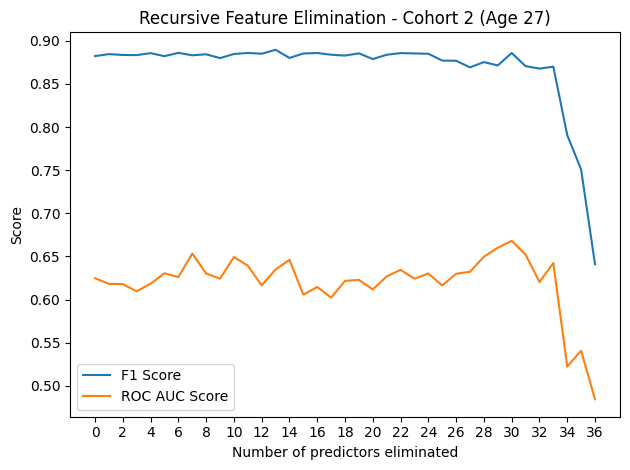

In [144]:
# RFE - X2
X2_rfe = X2_train
feature_names = X2_train.columns.values.tolist()
f1s_X2 = []
roc_aucs_X2 = []
feature_eliminate = []
imps_all = shap_absmean.tolist()

while len(feature_names) > 0:
    # Perform cross-validation
    scores = cross_val_scores(rf_final2, X2_rfe, y2_train)
    f1_avg = np.mean(scores[0])
    roc_auc_avg = np.mean(scores[1])
    
    print(f'F1 Score: {f1_avg}')
    f1s_X2.append(f1_avg)
    
    print(f'ROC AUC Score: {roc_auc_avg}')
    roc_aucs_X2.append(roc_auc_avg)
    
    # Identify least important feature
    least_imp_ind = np.argmin(imps_all)
    print(f'Eliminating feature: {feature_names[least_imp_ind]} (Index: {least_imp_ind})')
    
    # Drop the least important feature
    X2_rfe = X2_rfe.drop(feature_names[least_imp_ind], axis=1)
    feature_eliminate.append(feature_names[least_imp_ind])
    
    # Remove from feature names and importance list
    feature_names.pop(least_imp_ind)
    imps_all.pop(least_imp_ind)
    
    print(f'Remaining features: {X2_rfe.shape}')

# Plot the RFE curve for F1 Score
eli_X2 = range(len(f1s_X2))
plt.figure()
# Add plot title
plt.title('Recursive Feature Elimination - Cohort 2 (Age 27)')
plt.plot(eli_X2, f1s_X2, label="F1 Score")
plt.plot(eli_X2, roc_aucs_X2, label="ROC AUC Score")
plt.ylabel('Score')
plt.xlabel('Number of predictors eliminated')
plt.xticks(np.arange(0, len(f1s_X2), step=2))
plt.legend()
plt.tight_layout()
plt.savefig('RFE_plot_X2.png', dpi=1000)
plt.show()

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.34057856980782997
ROC AUC Score: 0.6200437066300671
Eliminating feature: ethni_Turkish.background (Index: 28)
Remaining features: (424, 36)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.327607966457023
ROC AUC Score: 0.6162237011354558
Eliminating feature: denomination_Other (Index: 33)
Remaining features: (424, 35)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.3004724799010513
ROC AUC Score: 0.615982782585873
Eliminating feature: abortion_X1 (Index: 18)
Remaining features: (424, 34)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.3333221146565995
ROC AUC Score: 0.6259421951364345
Eliminating feature: region_Eastern.Germany (Index: 27)
Remaining features: (424, 33)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.3219300540729112
ROC AUC Score: 0.6193093896563548
Eliminating feature: migback_X1 (Index: 18)
Remaining features: (424, 32)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.2911502937109073
ROC AUC Score: 0.6154085398874749
Eliminat

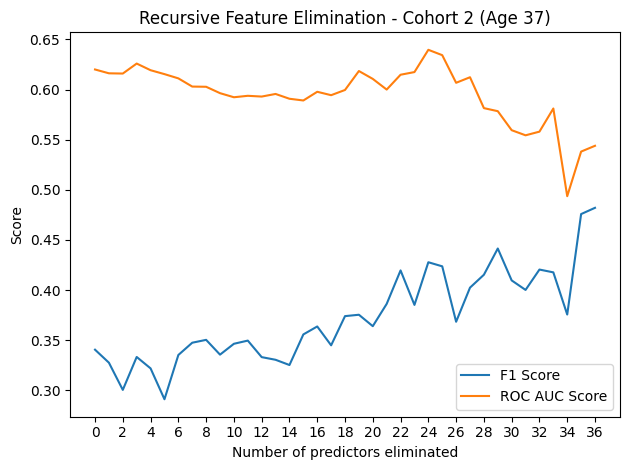

In [146]:
# RFE - X3
X3_rfe = X3_train
feature_names = X3_train.columns.values.tolist()
f1s_X3 = []
roc_aucs_X3 = []
feature_eliminate = []
imps_all = shap_absmean.tolist()

while len(feature_names) > 0:
    # Perform cross-validation
    scores = cross_val_scores(rf_final3, X3_rfe, y3_train)
    f1_avg = np.mean(scores[0])
    roc_auc_avg = np.mean(scores[1])
    
    print(f'F1 Score: {f1_avg}')
    f1s_X3.append(f1_avg)
    
    print(f'ROC AUC Score: {roc_auc_avg}')
    roc_aucs_X3.append(roc_auc_avg)
    
    # Identify least important feature
    least_imp_ind = np.argmin(imps_all)
    print(f'Eliminating feature: {feature_names[least_imp_ind]} (Index: {least_imp_ind})')
    
    # Drop the least important feature
    X3_rfe = X3_rfe.drop(feature_names[least_imp_ind], axis=1)
    feature_eliminate.append(feature_names[least_imp_ind])
    
    # Remove from feature names and importance list
    feature_names.pop(least_imp_ind)
    imps_all.pop(least_imp_ind)
    
    print(f'Remaining features: {X3_rfe.shape}')

# Plot the RFE curve for F1 Score
eli_X3 = range(len(f1s_X3))
plt.figure()
# Add plot title
plt.title('Recursive Feature Elimination - Cohort 2 (Age 37)')
plt.plot(eli_X3, f1s_X3, label="F1 Score")
plt.plot(eli_X3, roc_aucs_X3, label="ROC AUC Score")
plt.ylabel('Score')
plt.xlabel('Number of predictors eliminated')
plt.xticks(np.arange(0, len(f1s_X3), step=2))
plt.legend()
plt.tight_layout()
plt.savefig('RFE_plot_X3.png', dpi=1000)
plt.show()

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.6313887579657109
ROC AUC Score: 0.6582727479444772
Eliminating feature: ethni_Turkish.background (Index: 28)
Remaining features: (530, 36)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.6229498313435393
ROC AUC Score: 0.6602578888798001
Eliminating feature: denomination_Other (Index: 33)
Remaining features: (530, 35)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.6266805117033986
ROC AUC Score: 0.6568643542690296
Eliminating feature: abortion_X1 (Index: 18)
Remaining features: (530, 34)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.620781471245273
ROC AUC Score: 0.6580335949140712
Eliminating feature: region_Eastern.Germany (Index: 27)
Remaining features: (530, 33)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.63563195572364
ROC AUC Score: 0.6650010313458671
Eliminating feature: migback_X1 (Index: 18)
Remaining features: (530, 32)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
F1 Score: 0.6390358487001758
ROC AUC Score: 0.6585248153785767
Eliminatin

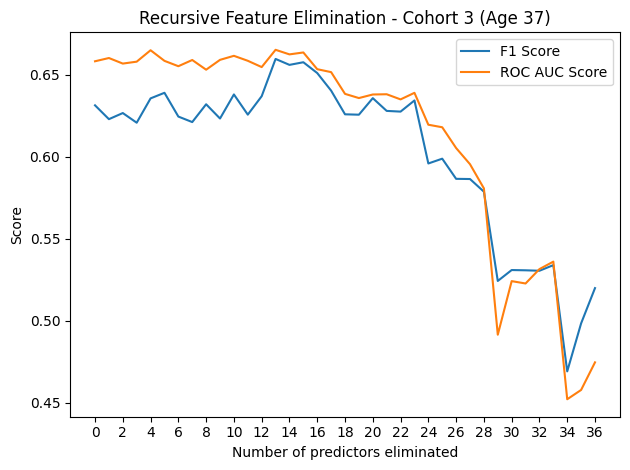

In [147]:
# RFE - X4
X4_rfe = X4_train
feature_names = X4_train.columns.values.tolist()
f1s_X4 = []
roc_aucs_X4 = []
feature_eliminate = []
imps_all = shap_absmean.tolist()

while len(feature_names) > 0:
    # Perform cross-validation
    scores = cross_val_scores(rf_final4, X4_rfe, y4_train)
    f1_avg = np.mean(scores[0])
    roc_auc_avg = np.mean(scores[1])
    
    print(f'F1 Score: {f1_avg}')
    f1s_X4.append(f1_avg)
    
    print(f'ROC AUC Score: {roc_auc_avg}')
    roc_aucs_X4.append(roc_auc_avg)
    
    # Identify least important feature
    least_imp_ind = np.argmin(imps_all)
    print(f'Eliminating feature: {feature_names[least_imp_ind]} (Index: {least_imp_ind})')
    
    # Drop the least important feature
    X4_rfe = X4_rfe.drop(feature_names[least_imp_ind], axis=1)
    feature_eliminate.append(feature_names[least_imp_ind])
    
    # Remove from feature names and importance list
    feature_names.pop(least_imp_ind)
    imps_all.pop(least_imp_ind)
    
    print(f'Remaining features: {X4_rfe.shape}')

# Plot the RFE curve for F1 Score
eli_X4 = range(len(f1s_X4))
plt.figure()
# Add plot title
plt.title('Recursive Feature Elimination - Cohort 3 (Age 37)')
plt.plot(eli_X4, f1s_X4, label="F1 Score")
plt.plot(eli_X4, roc_aucs_X4, label="ROC AUC Score")
plt.ylabel('Score')
plt.xlabel('Number of predictors eliminated')
plt.xticks(np.arange(0, len(f1s_X4), step=2))
plt.legend()
plt.tight_layout()
plt.savefig('RFE_plot_X4.png', dpi=1000)
plt.show()

### Plots

In [38]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x000002B9F8EACA10>, show_values_in_legend=False, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.

    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.

    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand

    feature_names :

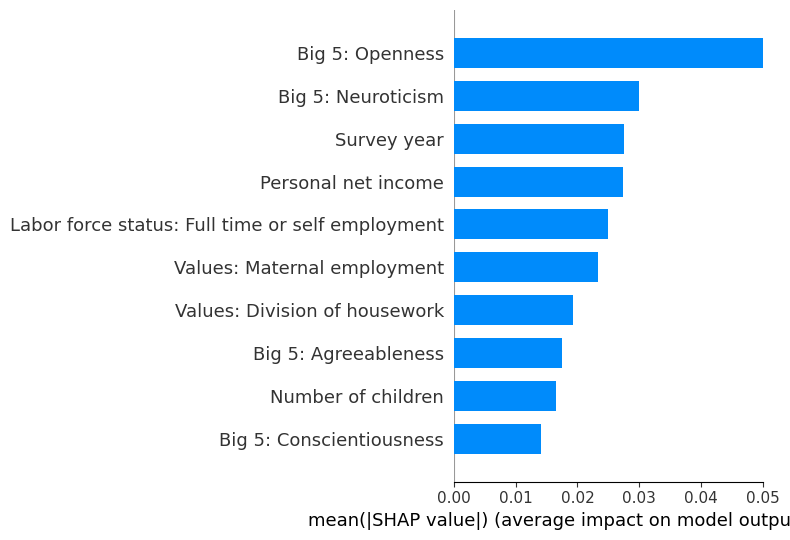

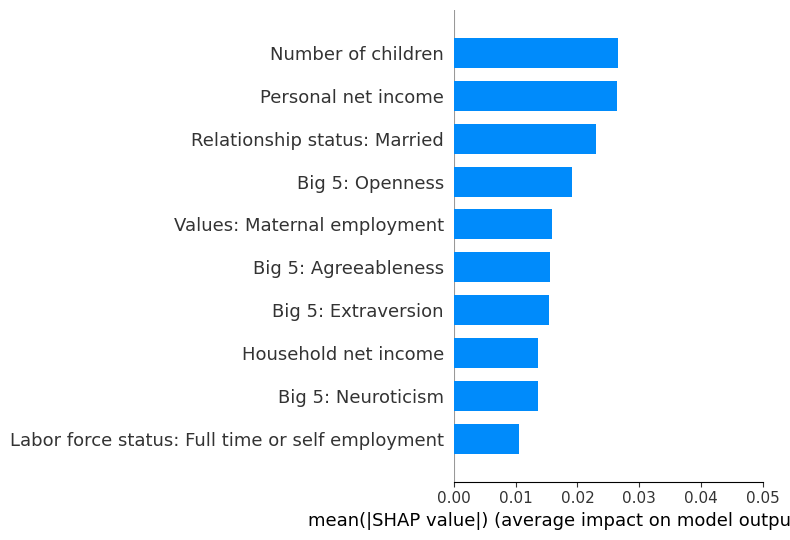

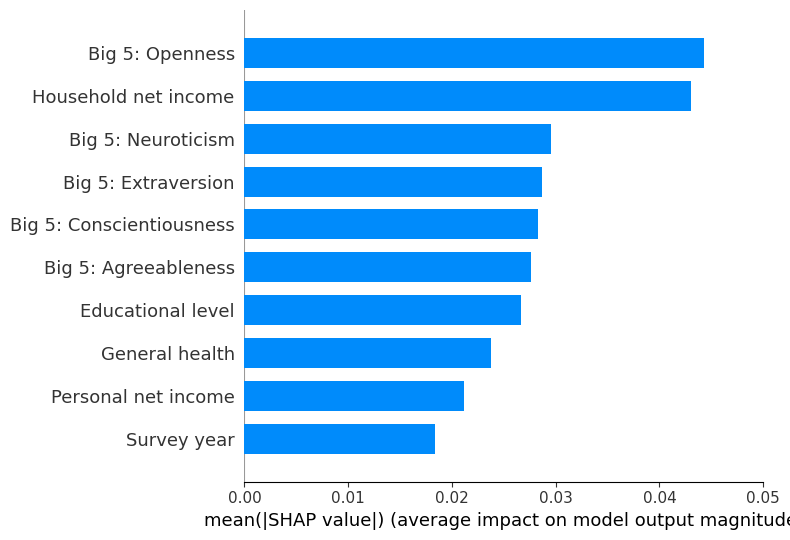

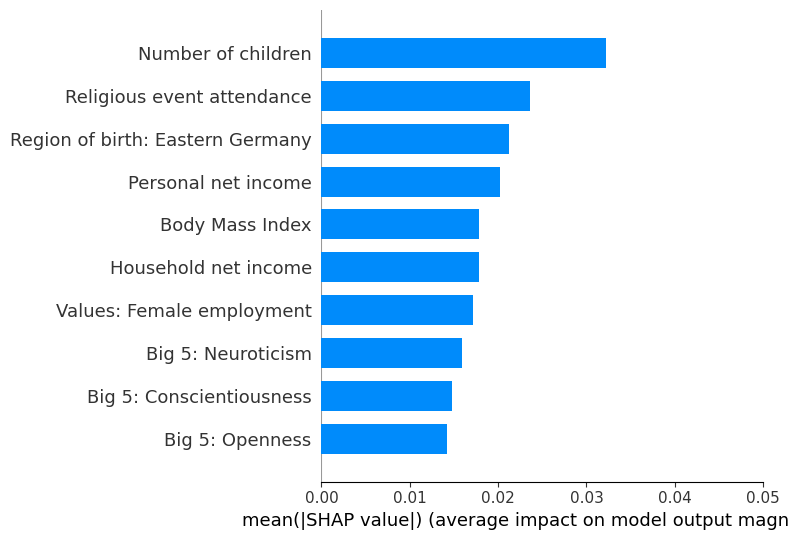

In [154]:
# Plot SHAP Bar Plot
plt.xlim(0, 0.05)
shap.summary_plot(shap_values_Tree1[:, :, 1], X1_train, plot_type='bar', max_display=10, feature_names= feature_names_list)

plt.xlim(0, 0.05)
shap.summary_plot(shap_values_Tree2[:, :, 1], X2_train, plot_type='bar', max_display=10, feature_names= feature_names_list)

plt.xlim(0, 0.05)
shap.summary_plot(shap_values_Tree3[:, :, 1], X3_train, plot_type='bar', max_display=10, feature_names= feature_names_list)

plt.xlim(0, 0.05)
shap.summary_plot(shap_values_Tree4[:, :, 1], X4_train, plot_type='bar', max_display=10, feature_names= feature_names_list)

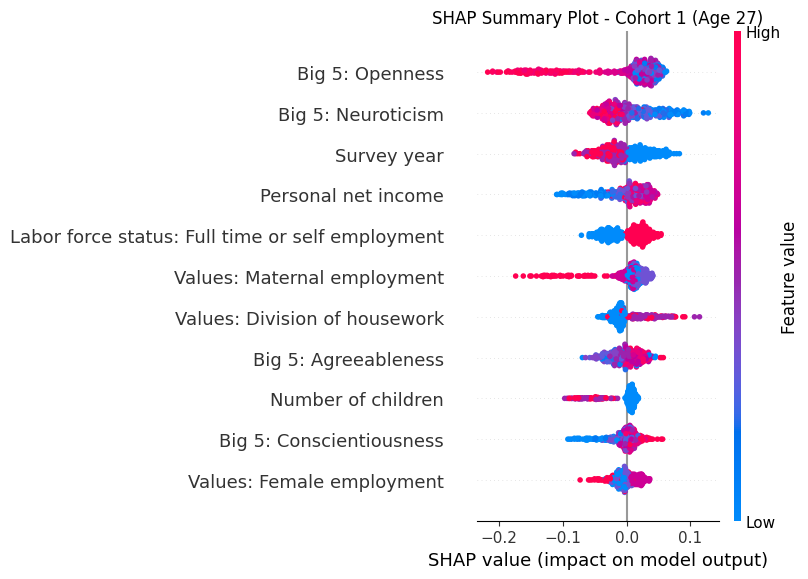

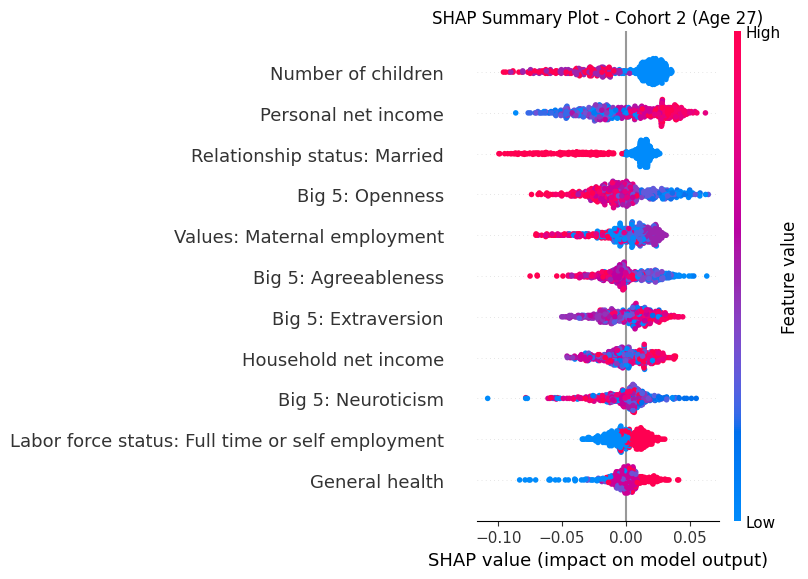

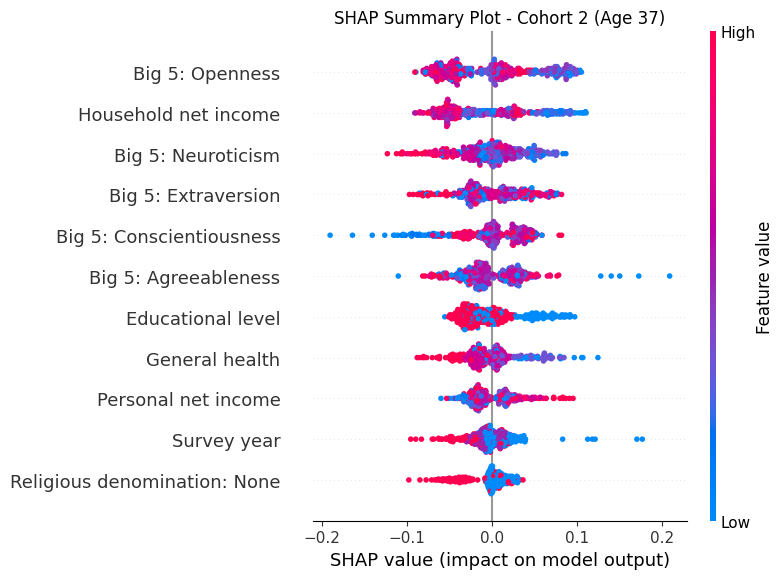

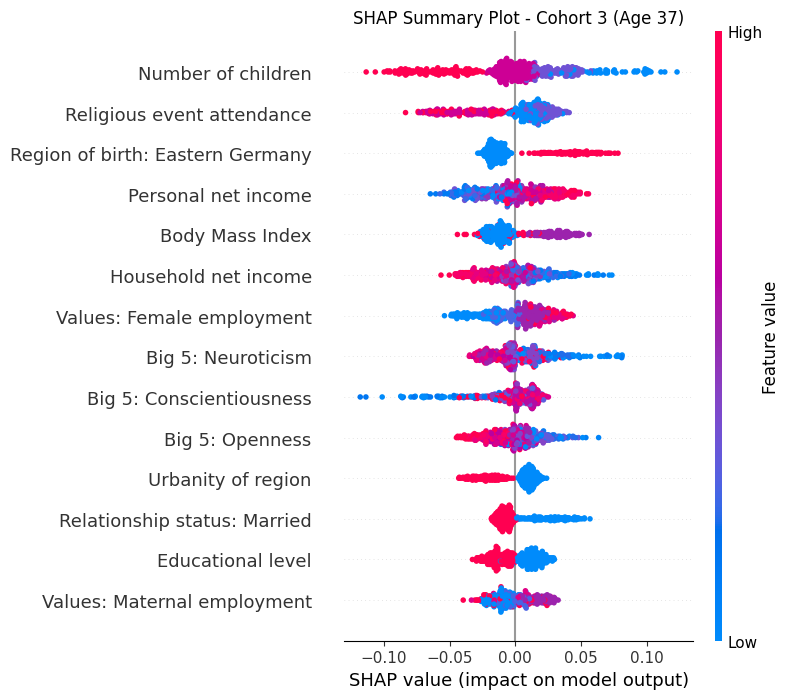

In [8]:
# Plots SHAP Beeswarm plot
plt.title('SHAP Summary Plot - Cohort 1 (Age 27)')
shap.summary_plot(shap_values_Tree1[:, :, 1], X1_train, 
                  plot_type='dot', 
                  feature_names = feature_names_list,
                  #plot_size=(15, 10),
                  max_display = 11)

plt.title('SHAP Summary Plot - Cohort 2 (Age 27)')
shap.summary_plot(shap_values_Tree2[:, :, 1], X2_train, 
                  plot_type='dot', 
                  feature_names = feature_names_list,
                  #plot_size=(15, 10),
                  max_display = 11)

plt.title('SHAP Summary Plot - Cohort 2 (Age 37)')
shap.summary_plot(shap_values_Tree3[:, :, 1], X3_train, 
                  plot_type='dot', 
                  feature_names = feature_names_list,
                  #plot_size=(15, 10),
                  max_display = 11)

plt.title('SHAP Summary Plot - Cohort 3 (Age 37)')
shap.summary_plot(shap_values_Tree4[:, :, 1], X4_train, 
                  plot_type='dot', 
                  feature_names = feature_names_list,
                  #plot_size=(15, 10),
                  max_display = 14)